In [1]:
# import library 
import pandas as pd
import numpy as np 

In [2]:
# import data
inference = pd.read_csv('northwind_data_mart.csv', parse_dates=['tanggal_pesan','estimasi_tiba','tanggal_tiba'])

#### Apakah *diskon* memiliki perbedaan signifikan terhadap *jumlah transaksi*?

##### Parametric Test (Independent T-test)

In [3]:
# pisahkan data 
df_disc = inference[inference['diskon'] == 0]['jumlah_transaksi']
df_no_disc = inference[inference['diskon'] > 0]['jumlah_transaksi']

In [4]:
# transformasi
cols_num = ['harga','jumlah_transaksi','diskon','lama_pengiriman','revenue','tahun']
inference_log = np.log1p(inference[cols_num])
inference_log

# pisahkan data 
df_disc_log = inference_log[inference_log['diskon'] == 0]['jumlah_transaksi']
df_no_disc_log = inference_log[inference_log['diskon'] > 0]['jumlah_transaksi']

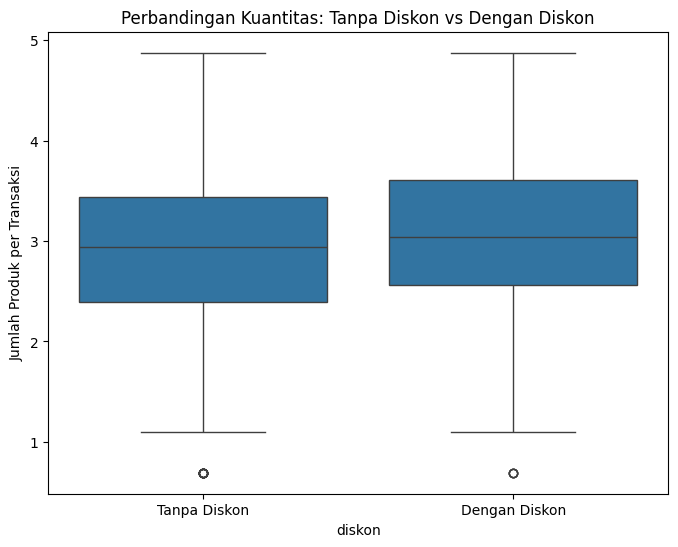

In [5]:
# sebaran data 
import matplotlib.pyplot as plt
import seaborn as sns 

plt.figure(figsize=(8, 6))
sns.boxplot(x=(inference_log['diskon'] > 0), y=inference_log['jumlah_transaksi'])
plt.title('Perbandingan Kuantitas: Tanpa Diskon vs Dengan Diskon')
plt.xticks([0, 1], ['Tanpa Diskon', 'Dengan Diskon'])
plt.ylabel('Jumlah Produk per Transaksi')
plt.show()

**Uji Hipotesis**

- $H_0$ : Rata-rata kuantitas kelompok diskon $=$ rata-rata kuantitas kelompok tanpa diskon.
- $H_1$ : Rata-rata kuantitas kelompok diskon $\neq$ rata-rata kuantitas kelompok tanpa diskon.

In [6]:
import numpy as np 

print(f'Varians kelompok diskon: {np.var(df_disc_log)}')
print(f'Varians kelompok non diskon: {np.var(df_no_disc_log)}')

Varians kelompok diskon: 0.6172271225755366
Varians kelompok non diskon: 0.6185041146343018


In [7]:
# Melakukan T-Test
from scipy import stats 

t_stat, p_value = stats.ttest_ind(df_no_disc_log, df_disc_log, equal_var=True)

print(f"Rata-rata Tanpa Diskon: {df_no_disc_log.mean():.2f}")
print(f"Rata-rata Dengan Diskon: {df_disc_log.mean():.2f}")
print(f"P-Value: {p_value:.4f}")

# Interpretasi
alpha = 0.05
if p_value < alpha:
    print("Kesimpulan: Ada perbedaan signifikan, Diskon berpengaruh pada jumlah transaksi.")
else:
    print("Kesimpulan: Tidak ada perbedaan signifikan. Diskon mungkin tidak efektif.")

Rata-rata Tanpa Diskon: 3.06
Rata-rata Dengan Diskon: 2.84
P-Value: 0.0000
Kesimpulan: Ada perbedaan signifikan, Diskon berpengaruh pada jumlah transaksi.


In [8]:
# effect size (cohen's d)
import pingouin as pg

d = np.round(np.abs(pg.compute_effsize(df_disc_log, df_no_disc_log, eftype='cohen')), 2)
print(f"Cohen's d: {d}")

Cohen's d: 0.28


<div align = 'justify'>
Nilai `Cohen's d = 0.28` yang berarti meskipun perbedaannya signifikan, namun secara praktis efeknya kecil. Mungkin disarankan untuk mengubah skema diskon daripada dihentikan total
</div>

In [9]:
# back transformation
mean_original_non = np.expm1(df_no_disc_log.mean())
mean_original_dis = np.expm1(df_disc_log.mean())

print(f"P-Value (Log-scale): {p_value:.5f}")
print(f"Rata-rata Back-transformed (Tanpa Diskon): {mean_original_non:.2f}")
print(f"Rata-rata Back-transformed (Dengan Diskon): {mean_original_dis:.2f}")

P-Value (Log-scale): 0.00000
Rata-rata Back-transformed (Tanpa Diskon): 20.39
Rata-rata Back-transformed (Dengan Diskon): 16.15


| VARIABEL       | MEAN DATA ASLI (RAW) | MEAN DATA LOG-TRANSFORM | MEAN BACK-TRANSFORM |
|----------------|-----------------|--------------------|----------------|
| Tanpa Diskon   | 27.11           | 3.06               | **20.39**          |
| Dengan Diskon  | 21.72           | 2.84               | **16.15**          |

<div align='justify'>
Strategi diskon saat ini memberikan hasil yang berlawanan dengan ekspektasi. Bukan hanya gagal meningkatkan transaksi, tetapi pelanggan yang menggunakan diskon rata-rata bertransaksi 4 unit lebih rendah (selisih 20 dan 16) dibandingkan mereka yang membayar harga penuh.
</div>

##### Non Parametric Test (Mann Whitney-u)

In [10]:
from scipy import stats

# Menghitung Median (Lebih tahan terhadap outlier dibanding Rata-rata)
median_tanpa_diskon = df_no_disc.median()
median_dengan_diskon = df_disc.median()

print(f"Median Tanpa Diskon: {median_tanpa_diskon}")
print(f"Median Dengan Diskon: {median_dengan_diskon}")

# Menjalankan Mann-Whitney U Test
stat, p_val_mw = stats.mannwhitneyu(df_no_disc, df_disc, alternative='two-sided')

print(f"\nP-Value Mann-Whitney U: {p_val_mw:.5f}")

# Interpretasi
if p_val_mw < 0.05:
    print("Kesimpulan: Ada perbedaan signifikan secara statistik (berdasarkan peringkat).")
else:
    print("Kesimpulan: Tidak ada perbedaan signifikan secara statistik.")

Median Tanpa Diskon: 20.0
Median Dengan Diskon: 18.0

P-Value Mann-Whitney U: 0.00000
Kesimpulan: Ada perbedaan signifikan secara statistik (berdasarkan peringkat).


| Kelompok | N (Jumlah Data) | Median | P-Value (Mann-Whitney) | Signifikansi |
| ----- | ----- | ----- | ----- | ----- |
| Tanpa Diskon | 1.317 | 20.0 | < 0.05 | Signifikan |
| Dengan Diskon | 838 | 18.0 | < 0.05 | Signifikan |

Temuan : 
<div align = 'justify'>

Hasil uji menunjukkan adanya perbedaan yang signifikan secara statistik antara kedua kelompok ($U$ statistik, $p < 0.05$). Kelompok Tanpa Diskon memiliki nilai Median = 20.0, yang secara signifikan lebih tinggi dibandingkan kelompok Dengan Diskon yang memiliki nilai Median = 18.0. Hal ini menunjukkan bahwa kecenderungan jumlah transaksi lebih tinggi terjadi pada saat tidak diberikan diskon.

Karena P-Value yang dihasilkan sangat kecil (0.00000), probabilitas bahwa perbedaan ini terjadi karena faktor kebetulan hampir nol. Perbedaan perilaku belanja ini bersifat nyata dan konsisten.

</div>

#### Analisis diskon terhadap masing-masing kategori produk

In [11]:
# List kosong untuk menyimpan hasil
results = []

# Analisis per kategori
categories = inference['kategori_produk'].unique()

for cat in categories:
    cat_data = inference[inference['kategori_produk'] == cat]
    
    group_no = cat_data[cat_data['diskon'] == 0]['jumlah_transaksi']
    group_yes = cat_data[cat_data['diskon'] > 0]['jumlah_transaksi']
    
    # Hitung T-Test
    t_stat, p_val = stats.ttest_ind(group_no, group_yes, equal_var=False)
    
    results.append({
        'Category': cat,
        'Avg No Discount': group_no.mean(),
        'Avg Discount': group_yes.mean(),
        'P-Value': p_val,
        'Significant': 'Yes' if p_val < 0.05 else 'No'
    })

# Ubah ke DataFrame
df_results = pd.DataFrame(results)
print(df_results)

         Category  Avg No Discount  Avg Discount   P-Value Significant
0  Dairy Products        22.165179     29.464789  0.000466         Yes
1  Grains/Cereals        22.744361     24.396825  0.551448          No
2         Produce        20.956044     24.066667  0.404978          No
3         Seafood        21.358974     26.044444  0.029457         Yes
4      Condiments        21.320611     29.470588  0.006932         Yes
5     Confections        23.090000     24.537313  0.445995          No
6       Beverages        20.796748     27.949367  0.000578         Yes
7    Meat/Poultry        20.721649     28.802632  0.020528         Yes


<div align='justify'>

Untuk kategori:
- *`Dairy Products, Seafood, Condiments, Beverages, Meat/Poultry`* strategi diskon berhasil. Pelanggan benar-benar membeli banyak saat diberikan diskon.
- *`Grains/Cereals, Produce, Confections`* strategi diskon kurang efektif. Meskipun rata-rata kuantitas mungkin terlihat naik, secara statistik itu tidak kuat. Disarankan untuk tidak memberikan diskon agar keuntungan margin terjaga atau dengan mencari promosi lain seperti *bundling*

</div>

In [12]:
# Menyiapkan data untuk masing-masing shipper
speedy = inference[inference['nama_jasa_pengiriman'] == 'Speedy Express']['lama_pengiriman']
united = inference[inference['nama_jasa_pengiriman'] == 'United Package']['lama_pengiriman']
federal = inference[inference['nama_jasa_pengiriman'] == 'Federal Shipping']['lama_pengiriman']

# 1. Jalankan One-Way ANOVA
f_stat, p_val = stats.f_oneway(speedy, united, federal)

print(f"F-Statistic: {f_stat:.4f}")
print(f"P-Value: {p_val:.4f}")

if p_val < 0.05:
    print("Kesimpulan: Ada perbedaan signifikan antar ekspedisi!")
else:
    print("Kesimpulan: Tidak ada perbedaan signifikan. Semua ekspedisi sama cepatnya.")

F-Statistic: 21.5039
P-Value: 0.0000
Kesimpulan: Ada perbedaan signifikan antar ekspedisi!


In [13]:
# Uji Tukey HSD
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=inference['lama_pengiriman'], 
                          groups=inference['nama_jasa_pengiriman'], 
                          alpha=0.05)

print(tukey)

         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
     group1          group2     meandiff p-adj   lower  upper  reject
---------------------------------------------------------------------
Federal Shipping Speedy Express   0.8306 0.0731 -0.0589   1.72  False
Federal Shipping United Package   2.2668    0.0  1.4353 3.0983   True
  Speedy Express United Package   1.4362 0.0002  0.6051 2.2674   True
---------------------------------------------------------------------


- Federal Shipping jika dibandingkan dengan Speedy Express tidak ada perbedaan lama pengiriman yang signifikan.
- United Package lebih lama 1-2 hari jika dibandingkan dengan Federal Shipping dan Speedy Express.

- `reject = False` berarti tidak ada perbedaan signifikan dari kedua grup
- `reject = True` berarti ada perbedaan signifikan dari kedua grup
- `meandiff > 0` berarti grup 2 lebih lambat
- `meandiff < 0` berarti grup 2 lebih cepat